# Notas de matemática do ENEM 2016

Business Problem: Este [desafio](https://www.codenation.dev/aceleradev/ds-online-1/challenge/enem-ps) faz parte do programa de aceleração da [Codenation](https://www.codenation.dev/). O objetivo é criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016.

Os datasets estão disponíveis na página do [desafio](https://www.codenation.dev/aceleradev/ds-online-1/challenge/enem-ps). Eu utilizei o Google Colab. Assim, fiz o upload dos arquivos no Drive e acessei via PyDrive, conforme as próximas células.


In [1]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"ABC"})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.csv')

In [0]:
downloaded = drive.CreateFile({'id':"ABC"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv')

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [8]:
print(train.shape, test.shape)

(13730, 167) (4576, 47)


**Datasets**: O conjunto de treino possui dados de 13730 alunos com 167 variáveis para cada um deles. O conjunto de teste possui 47 variáveis e um total de 4576 alunos.

## Análise de dados faltantes (Missing Values)

Os dois conjuntos possuem muitos dados faltantes NaN. Como pode ver observado nas próximas células.

In [0]:
#Função para verificar quais colunas possuem valores nulos
def getMissing(data):
  total = data.isnull().sum().sort_values(ascending=False)
  percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  missing_data.sort_values(by='Total', ascending=False, inplace=True)
  print(missing_data[missing_data['Total'] > 0])

In [10]:
getMissing(train)

                             Total    Percent
CO_UF_ENTIDADE_CERTIFICACAO  12092  88.069920
SG_UF_ENTIDADE_CERTIFICACAO  12092  88.069920
NO_ENTIDADE_CERTIFICACAO     12092  88.069920
Q041                         10792  78.601602
TP_SIT_FUNC_ESC               9448  68.812819
TP_LOCALIZACAO_ESC            9448  68.812819
TP_DEPENDENCIA_ADM_ESC        9448  68.812819
CO_UF_ESC                     9448  68.812819
NO_MUNICIPIO_ESC              9448  68.812819
CO_ESCOLA                     9448  68.812819
TP_ENSINO                     9448  68.812819
SG_UF_ESC                     9448  68.812819
CO_MUNICIPIO_ESC              9448  68.812819
Q033                          7376  53.721777
Q032                          7376  53.721777
Q031                          7376  53.721777
Q028                          7376  53.721777
Q029                          7375  53.714494
Q030                          7375  53.714494
Q027                          7373  53.699927
NU_NOTA_COMP3                 3597

In [11]:
getMissing(test)

                        Total    Percent
TP_ENSINO                3096  67.657343
TP_DEPENDENCIA_ADM_ESC   3096  67.657343
Q027                     2488  54.370629
NU_NOTA_COMP2            1199  26.201923
NU_NOTA_COMP5            1199  26.201923
NU_NOTA_COMP3            1199  26.201923
NU_NOTA_REDACAO          1199  26.201923
NU_NOTA_COMP1            1199  26.201923
NU_NOTA_LC               1199  26.201923
NU_NOTA_COMP4            1199  26.201923
TP_STATUS_REDACAO        1199  26.201923
NU_NOTA_CH               1134  24.781469
NU_NOTA_CN               1134  24.781469


Antes de prosseguir, as seguintes abreviações podem aparecer durante a análise:
*   CN: Ciências da Natureza;
*   CH: Ciências Humanas;
*   LC: Linguagens e códigos;
*   MT: Matemática.


Em primeira análise, poderia seguir dois caminhos: excluir as linhas com dados faltantes ou inserir esses dados utilizando a média da variável ou moda, por exemplo. A experimentação com esses métodos funcionou razoavelmente, com uma pontuação aproximada de 76% no desafio da Codenation. 

O erro dessa abordagem foi não verificar porque esses dados estavam faltando, principalmente na variável target NU_NOTA_MT (nota de matemática).

Ao analisar o dicionário de microdados, encontrei as variáveis de presença nas provas ('TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'), e ficou facilmente verificado que os alunos que não compareceram (código 0) ou foram eliminados (código 2) na prova de matemática e linguagens e códigos estavam com notas NaN na variável NU_NOTA_MT. Isso explica que essas provas eram realizadas no mesmo dia e esses alunos deveriam ter as notas zeradas. 

Dessa forma, apesar dos primeiros métodos terem um score de 76%, as notas de muitos alunos estava completamente errada. Pois mesmo não comparecendo na prova, o modelo de Machine Learning atribuia alguma nota para eles. 

Então, nas próximas células verifico os alunos faltantes e faço uma limpeza nos dados NaN.



In [13]:
#Verificar quem não fez a prova
train[['TP_PRESENCA_LC', 'TP_PRESENCA_MT']].apply(pd.Series.value_counts)

,TP_PRESENCA_LC,TP_PRESENCA_MT
1,10133,10133
0,3592,3592
2,5,5


Assim, alunos que terão notas zeradas (serão excluídos) em LC e MT:

*   3592 não fizeram a prova LC e MT;
*   5 foram desclassificados.

In [0]:
#Excluir alunos que não fizeram a prova MT ou foram desclassificados
train = train.loc[train['TP_PRESENCA_MT'] == 1]

In [15]:
#Verificar quem não fez a prova
train[['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']].apply(pd.Series.value_counts)

,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT
0,32,32,NaN,NaN
1,10097,10097,10133.0,10133.0
2,4,4,NaN,NaN




*   32 alunos fizeram prova de MT e LC e não fizeram CN e CH;
*   4 alunos foram desclassificados da prova CN e CH e não foram desclassificados da prova MT e LC.



In [0]:
#Atribuir nota zero para os alunos que não compareceram ou foram desclassificados
train['NU_NOTA_CN'].fillna(0, inplace=True)
train['NU_NOTA_CH'].fillna(0, inplace=True)

As colunas dos conjuntos de treino e teste são diferentes. Com isso, vou manter apenas as colunas que existem em ambos os conjuntos.

In [0]:
test_col = test.columns
train_col = train.columns
col_dif = list(set(train_col) - set(test_col))
col_dif.remove('NU_NOTA_MT')

In [0]:
#Remover as colunas do conjunto de treino que não existem no conjunto de teste
train.drop(col_dif, axis=1, inplace=True)

Ainda restaram algumas colunas com valores nulos. Como ultrapassam 50% dos dados, essas colunas serão removidas

In [23]:
getMissing(train)

                        Total    Percent
TP_DEPENDENCIA_ADM_ESC   6494  64.087634
TP_ENSINO                6494  64.087634
Q027                     6126  60.455936


In [0]:
#Deletar colunas com mais de 50% de nulos
all_data_na = (train.isnull().sum() / len(train)) * 100
train.drop(all_data_na[all_data_na > 50].index, axis=1, inplace=True)

In [25]:
getMissing(train)

Empty DataFrame
Columns: [Total, Percent]
Index: []


In [0]:
#Deletar as mesmas colunas no conjunto de teste
test.drop(all_data_na[all_data_na > 50].index, axis=1, inplace=True)

In [27]:
print(train.shape, test.shape)

(10133, 45) (4576, 44)


## Análise de Dados Faltantes (Missing Values) - Conjunto de teste

Aqui seguirei a mesma ideia do conjunto de treino. Verificar quem faltou a prova e atribuir nota 0. 

In [28]:
getMissing(test)

                   Total    Percent
TP_STATUS_REDACAO   1199  26.201923
NU_NOTA_LC          1199  26.201923
NU_NOTA_COMP1       1199  26.201923
NU_NOTA_COMP2       1199  26.201923
NU_NOTA_COMP3       1199  26.201923
NU_NOTA_COMP5       1199  26.201923
NU_NOTA_COMP4       1199  26.201923
NU_NOTA_REDACAO     1199  26.201923
NU_NOTA_CN          1134  24.781469
NU_NOTA_CH          1134  24.781469


In [29]:
#Verificar quem não fez a prova
test[['TP_PRESENCA_CN', 'TP_PRESENCA_CH']].apply(pd.Series.value_counts)

,TP_PRESENCA_CN,TP_PRESENCA_CH
1,3442,3442
0,1134,1134




*   1134 alunos do conjunto de teste não fizeram as provas CN e CH, esses alunos terão notas zeradas.



In [0]:
test['NU_NOTA_CN'].fillna(0, inplace=True)
test['NU_NOTA_CH'].fillna(0, inplace=True)

In [31]:
test['TP_PRESENCA_LC'].value_counts()

1    3377
0    1195
2       4
Name: TP_PRESENCA_LC, dtype: int64



*   1195 não fizeram a prova e 4 foram eliminados da prova de LC. Logo foram também eliminados da prova de redação e MT. Assim, todos esses alunos terão notas zeradas em MT e LC e Redação.



In [0]:
test.fillna(0, inplace=True)

In [33]:
getMissing(test)

Empty DataFrame
Columns: [Total, Percent]
Index: []


### Análise exploratória dos dados

A partir de agora nossos datasets não possuem mais dados nulos e posso começar a verificar as ligações entre os dados e o que mais impacta a nota de matemática. 

In [34]:
train.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,0,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,A
5,a37c99ec251d4f6e8ddbeabadf1c87fdbfddc4d1,29,BA,18,F,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,439.7,583.2,410.9,364.5,0,1.0,120.0,120.0,120.0,160.0,100.0,620.0,E,E,C,B,B,A,A
6,63b4e128e9ffe8ab27f5d093db1976ef4f353e0a,51,MT,18,F,3,1,2,0,2,0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,420.1,604.2,484.5,529.2,0,1.0,100.0,120.0,120.0,120.0,100.0,560.0,E,D,C,B,B,C,A
7,2eb189d4912f64b19d1967e8e84b6141aba18770,43,RS,18,F,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,619.6,625.8,611.2,566.7,0,1.0,140.0,120.0,120.0,120.0,120.0,620.0,G,F,L,B,B,A,D


Eu testei todas as correlações entre as variáveis e a nota de matemática. As principais correlações entre as variáveis categóricas foram as colunas 'TP_ESCOLA', 'CO_PROVA_MT', 'Q001',	'Q002',	'Q006',	'Q024',	'Q025',	'Q026',	'Q047'. Isso é verificado com um BoxPlot, conforme o próximo gráfico. 

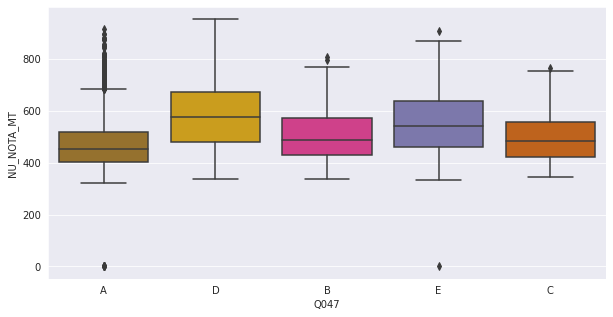

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(train['Q047'], train['NU_NOTA_MT'], palette="Dark2_r")

Para as variáveis contínuas utilizo um HeatMap para verificar a correlação com a nota de matemática. As variáveis com melhor correlação são 'NU_NOTA_CN',	'NU_NOTA_CH',	'NU_NOTA_LC',	'NU_NOTA_REDACAO'. 

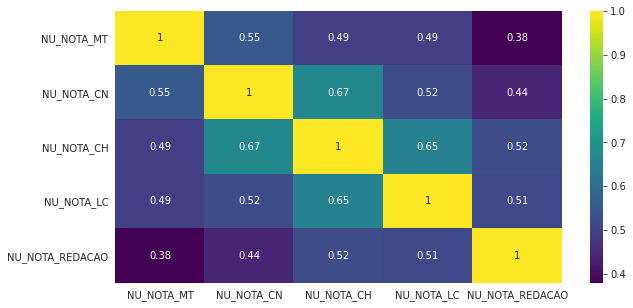

In [48]:
corr_num_Var = train[['NU_NOTA_CN',	'NU_NOTA_CH',	'NU_NOTA_LC',	'NU_NOTA_REDACAO', 'NU_NOTA_MT']].corr().abs()['NU_NOTA_MT'].sort_values( ascending=False)
plt.figure(figsize=(10,5))
sns.heatmap(train[corr_num_Var.index].corr().abs(), linecolor='white', annot=True, cmap='viridis')

In [0]:
#Selecionando as melhores variáveis
features = ['TP_ESCOLA', 'CO_PROVA_MT',
            'NU_NOTA_CN',	'NU_NOTA_CH',	'NU_NOTA_LC',	'NU_NOTA_REDACAO',
            'Q001',	'Q002',	'Q006',	'Q024',	'Q025',	'Q026',	'Q047']
features_dummies = ['TP_ESCOLA', 'CO_PROVA_MT', 'Q001',	'Q002',	'Q006',	'Q024',	'Q025',	'Q026',	'Q047']

Nesse ponto, os conjuntos de dados são reduzidos para apenas as variáveis com melhor correlação com a nota de matemática. 

In [0]:
y_train = train['NU_NOTA_MT']
train = train[features]
test = test[features]

In [51]:
print(train.shape, test.shape)

(10133, 13) (4576, 13)


Concatenando os dois conjuntos para aplicar a transformação Dummies das variáveis categóricas e Standard Scaler nas variáveis contínuas.

In [52]:
data = pd.concat([train, test], axis=0, ignore_index=True)
data.shape

(14709, 13)

In [0]:
data = pd.get_dummies(data, columns=features_dummies, drop_first=True)

In [54]:
data.shape

(14709, 56)

In [0]:
featuresNum = ['NU_NOTA_CN',	'NU_NOTA_CH',	'NU_NOTA_LC',	'NU_NOTA_REDACAO',]

from sklearn import preprocessing

#min_max_scaler = preprocessing.MinMaxScaler()
#min_max_scaler_y = preprocessing.MinMaxScaler()

#StandardScaler transformation
standardScaler = preprocessing.StandardScaler()
data[featuresNum] = standardScaler.fit_transform(data[featuresNum])

#data[featuresNum] = min_max_scaler.fit_transform(data[featuresNum])

In [0]:
#Separando novamente os conjuntos
train = data.head(train.shape[0])

test = data.tail(test.shape[0])

In [0]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Criando os conjuntos de treino e test para o modelo de regressão
XX_train, XX_test, yy_train, yy_test = train_test_split(train, y_train, test_size=0.23, random_state=42)

## Modelagem

Utilizei um modelo de regressão XGBRegressor com parâmetros normais. Isso já é suficiente para um bom desempenho. 

In [58]:
xgb_model = XGBRegressor()

xgb_model.fit(XX_train, yy_train, verbose=False)
y_pred_xgb = xgb_model.predict(XX_test)

np.sqrt(mean_squared_error(yy_test, y_pred_xgb))

[23:24:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


74.17787456396435

In [0]:
#Criando um dataframe para submissão
subm = pd.read_csv('test.csv')

#Fazendo as previsões para o conjunto de test
subm['NU_NOTA_MT'] = xgb_model.predict(test)

In [0]:
#Como o modelo calculou alguma nota para quem não fez a prova, nesse ponto esses alunos terão as notas zeradas. 
for index, row in subm.iterrows():
  if( row['TP_PRESENCA_LC'] == 0):
    subm.loc[index, 'NU_NOTA_MT'] = 0
  elif(row['TP_PRESENCA_LC'] == 2):
    subm.loc[index, 'NU_NOTA_MT'] = 0


In [0]:
#Separando apenas o número de inscrição e a nota para submeter o desafio
subm = subm[['NU_INSCRICAO','NU_NOTA_MT']]

In [62]:
subm.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,435.399017
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,444.962402
2,b38a03232f43b11c9d0788abaf060f7366053b6d,579.441650
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,562.778564


In [0]:
subm.to_csv("submission_colab.csv", index=False)

In [0]:
#Fazendo download do arquivo de resposta
from google.colab import files

os.chdir(r'/content')

files.download('submission_colab.csv')

## Conclusão

Então, esse modelo de Machine Learning atingiu uma pontuação de 93,71% no [desafio da Codenation](https://www.codenation.dev/aceleradev/ds-online-1/challenge/enem-ps). Pode parecer uma contrução trivial, mas se não for verificado o motivo de dados NaN na variável target, o modelo não terá uma acertividade próxima do real. 

O que aprendemos com ele? Não podemos ignorar nenhum dado sem análise, pois até em dados nulos podemos ter a resposta para o que estamos procurando. 